# Mathematical Modeling of AZ Covid Data

In this notebook, we organize and visualize Covid-19 hospitalization data for the state of Arizona, and then attmept to model the first 160 days using a dynamical system. If you would like to follow along with this notebook, you can download the data from [HealthData.gov](https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh).

In [42]:
#Import the necessary packages to visualize our data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Load the data from csv file into a pandas dataframe
covid_pd = pd.read_csv('Covid-19.csv', parse_dates = ['date'])

#Visualize the first few rows of our dataframe
covid_pd.head()

,state,date,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,hospital_onset_covid_coverage,...,previous_day_admission_pediatric_covid_confirmed_5_11,previous_day_admission_pediatric_covid_confirmed_5_11_coverage,previous_day_admission_pediatric_covid_confirmed_unknown,previous_day_admission_pediatric_covid_confirmed_unknown_coverage,staffed_icu_pediatric_patients_confirmed_covid,staffed_icu_pediatric_patients_confirmed_covid_coverage,staffed_pediatric_icu_bed_occupancy,staffed_pediatric_icu_bed_occupancy_coverage,total_staffed_pediatric_icu_beds,total_staffed_pediatric_icu_beds_coverage
0,RI,2021-02-13,4,10,1,4,10,1,5.0,14,...,NaN,0,NaN,0,NaN,0,74.0,14,80.0,14
1,AK,2021-02-05,1,23,0,1,23,0,0.0,24,...,NaN,0,NaN,0,NaN,0,57.0,24,74.0,24
2,MA,2021-02-02,8,70,1,7,71,1,58.0,78,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
3,KS,2021-01-26,10,128,3,16,122,3,3.0,138,...,NaN,0,NaN,0,NaN,0,38.0,138,219.0,138
4,MD,2021-01-20,2,56,1,2,56,1,30.0,58,...,NaN,0,NaN,0,NaN,0,164.0,58,241.0,58


In [43]:
# Focus on hospitalizations using inpatient_beds_used_covid column
covid_pd = covid_pd[['state','date','inpatient_beds_used_covid']]
#Rename column
covid_pd.rename({'inpatient_beds_used_covid':'Hospitalizations'}, axis = 1, inplace = True)

In [44]:
covid_pd = covid_pd[covid_pd['state'] == 'AZ'] # Extract data for Arizona
covid_pd = covid_pd.sort_values('date') #Order based on date
#Re-visualize table
covid_pd.head()


,state,date,Hospitalizations
20720,AZ,2020-03-02,0.0
14351,AZ,2020-03-03,0.0
19060,AZ,2020-03-04,0.0
17686,AZ,2020-03-05,0.0
17615,AZ,2020-03-06,0.0


In [45]:
#Let's reset the index for this new sorted dataframe
covid_pd.reset_index(drop=True, inplace=True)
covid_pd.head()

,state,date,Hospitalizations
0,AZ,2020-03-02,0.0
1,AZ,2020-03-03,0.0
2,AZ,2020-03-04,0.0
3,AZ,2020-03-05,0.0
4,AZ,2020-03-06,0.0


In [46]:
#Plot covid data
plt.plot(covid_pd['date'], covid_pd['Hospitalizations'])
plt.xlabel('Date')
plt.ylabel('Number of Hospitalizations')
plt.title('AZ Covid Hospitalizations (2020 - 2023)')
plt.tick_params(axis='x', labelrotation = 45) # rotate X-lables to avoid overlap


Now let's see if we can use a system of differential equations to model the first major spike in hospitalizations. First, we'll edit our dataframe to only include dates up to 09/2020

In [47]:
covid_pd = covid_pd[covid_pd['date']<'2020-08-30']
plt.plot(covid_pd['date'], covid_pd['Hospitalizations'])
plt.xlabel('Date')
plt.ylabel('Number of Hospitalizations')
plt.title('AZ Covid Hospitalizations (2020 - 2023)')
plt.tick_params(axis='x', labelrotation = 45) # rotate X-lables to avoid overlap


To approximate this data, we will use the SIHR model:
\begin{align*}
\frac{dS}{dt} & = -\frac{\beta S I}{N} \\
\frac{dI}{dt} & = \frac{\beta S I}{N} - \gamma I \\
\frac{dH}{dt} & =  \gamma  f I - c  H \\
\frac{dR}{dt} & = \gamma (1-f) I + c  H
\end{align*}
In this model, infected people are progressed to the next stage H (hospitalization) or R (recovered) with the progression rate $\gamma$. Among these people, about $f=1\%$ of them developed severe symtoms and were hospitalized in early 2020. For those hospitalized, the daily recover rate was approximately $c=0.17$. 

Our aim is to find the infection rate, $\beta$ and progression rate $\gamma$ manually to fit the data. In order to do this, we will create sliders to vary these two parameters

In [48]:
#Import package to solve the system of differential equations
from scipy.integrate import odeint

#Create our Model

# Arizona Population from google search
N = 7.276 *(10**6)
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 1, 0
#Initial number of hospitalized individuals H0
H0 = 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - H0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
beta, gamma = .175, .05

#Add in parameters f and c, percent hospitalization and recovery rate (1/day)
f,c = 0.01, 0.17
# A grid of time points (in days)
t = np.linspace(0, 181, 181)

# The SIR model differential equations.
def deriv(y, t, N, beta, gamma,f,c):
    S, I, H, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dHdt = gamma*f*I-c*H
    dRdt = gamma * (1-f)*I + c*H
    return dSdt, dIdt, dHdt, dRdt

# Initial conditions vector
y0 = S0, I0, H0, R0
# Integrate the SIHR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma,f,c))
S, I, H, R = ret.T

<IPython.core.display.Javascript object>


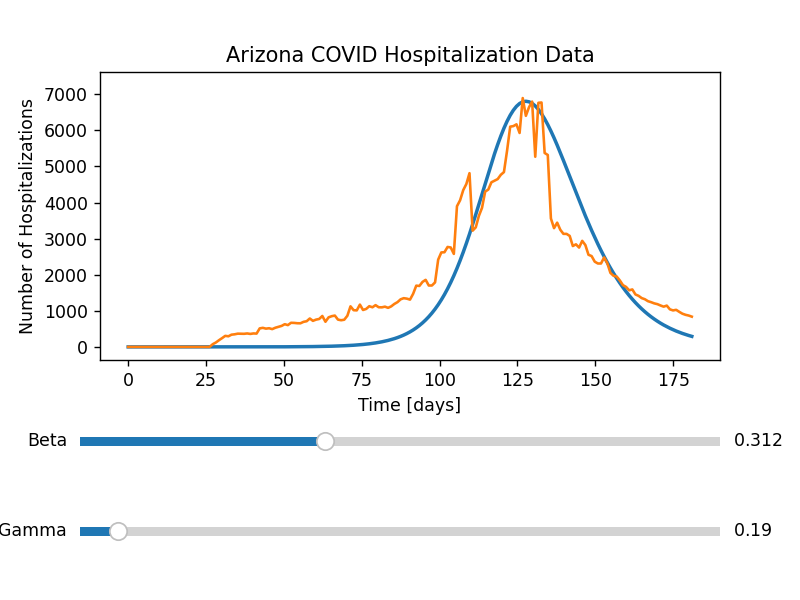

In [50]:
#Allows for interactive plot and slider functionality
%matplotlib notebook
from matplotlib.widgets import Slider

#Create a figure object and plot Covid Data and our solution, H
fig, ax = plt.subplots()
line, = ax.plot(t, H, lw=2) #This will be manipulated by our sliders
ax.plot(t,covid_pd['Hospitalizations'])
ax.set_xlabel('Time [days]')
ax.set_ylabel('Number of Hospitalizations')
ax.set_title('Arizona COVID Hospitalization Data')


# adjust the main plot to make room for the sliders
fig.subplots_adjust(bottom=0.4)

# Make a horizontal slider to control the gamma.
axgamma = fig.add_axes([0.1, 0.1, 0.8, 0.03])
gamma_slider = Slider(
    ax=axgamma,
    label='Gamma',
    valmin=0.01,
    valmax=3,
    valinit=0.19,
)

# Make another horizontal slider to control beta
axbeta = fig.add_axes([0.1, 0.25, 0.8, 0.03])
beta_slider = Slider(
    ax=axbeta,
    label="Beta",
    valmin=0.01,
    valmax=0.8,
    valinit= 0.3121,
)


# The function to be called anytime a slider's value changes
def update(val):
    ret = odeint(deriv, y0, t, args=(N, beta_slider.val, gamma_slider.val,f,c))
    S, I, H, R = ret.T
    line.set_ydata(H)
    fig.canvas.draw_idle()


# register the update function with each slider
beta_slider.on_changed(update)
gamma_slider.on_changed(update)

plt.show()

The parameters $\beta$ and $\gamma$ can be varied using our sliders to try to fit the data with our solution curve. I've found that values of $\beta=0.312$ and $\gamma = .19$ seem to approximate the data reasonably well, but one could continue to try different combinations to better fit our observed results. 